In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

from inchworm_measurement.simulator import Simulator
from pprint import pprint
from inchworm_measurement import utils
from inchworm_measurement.laser import Laser
from scipy.spatial.transform import Rotation


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


５点法 (直進)

In [9]:

def test_5points_straight():
    sigma = 0.00489 # size of pixel [mm] (nikon D800)
    focal = 8 # length of focal [mm] (NIKKOR 8-15mm f/3.5-4.5E)

    A = np.array([ 
        [focal/sigma, 0, 0],
        [0, focal/sigma, 0],
        [0, 0, 1]
    ])
    base_motion= np.array([
        [[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 100*i],
        [0, 0, 0, 1]] for i in range(1000)]
    )
    spotlaser_offset= np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 1000],
        [0, 0, 0, 1]
    ])
    ringlaser_offset = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 3250],
        [0, 0, 0, 1]
    ])

    n = 6
    spotlaser_origin = np.zeros((3, n))
    spotlaser_direction = np.array(
        [[np.cos(i * np.pi / n * 2), np.sin(i * np.pi / n * 2), 1] for i in range(n)]
    ).T

    m = 100
    ringlaser_origin = np.zeros((3, m))
    ringlaser_direction = np.array(
        [[np.cos(i * np.pi / m * 2), np.sin(i * np.pi / m * 2), 0] for i in range(m)]
    ).T

    simulator_params = {
        "A": A, 
        "spot_laser": Laser(spotlaser_origin, spotlaser_direction), 
        "ring_laser": Laser(ringlaser_origin, ringlaser_direction), 
        "spotlaser_offset": spotlaser_offset, 
        "ringlaser_offset": ringlaser_offset, 
        "cylinder_radius": 2500, 
        "base_motion": base_motion,
        "is_ring_with_camera": True, 
        "idx_length": 50,
        "idx_period": 5,
        "round_threshold": 0.5, 
        "is_three_points_algorithm": False, 
        "is_bundle": True, 
        "is_5points_true": False, 
        "is_scale_true": False, 
    }

    S = Simulator(simulator_params)
    S.run()

    zlim = [500,12000]
    S.show_result(zlim = zlim)
    S.show_result( zlim = zlim,is_groundtruth=True)

５点法(回転)

In [10]:
def test_5points_rotation():
    sigma = 0.00489 # size of pixel [mm] (nikon D800)
    focal = 8 # length of focal [mm] (NIKKOR 8-15mm f/3.5-4.5E)

    A = np.array([ 
        [focal/sigma, 0, 0],
        [0, focal/sigma, 0],
        [0, 0, 1]
    ])
    base_motion = []
    for i in range(1000):
        max_deg = 3
        deg = (np.min([i%(max_deg*4), (max_deg*4)-i%(max_deg*4)])-max_deg)
        R = Rotation.from_rotvec([deg*np.pi/180,0,0]).as_matrix()
        t = np.array([[0,0, 100*i]]).T
        base_motion.append(np.vstack([np.hstack([R,t]), np.array([[0,0,0,1]])]))
    base_motion = np.array(base_motion)

    spotlaser_offset= np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 1000],
        [0, 0, 0, 1]
    ])
    ringlaser_offset = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 3250],
        [0, 0, 0, 1]
    ])

    n = 6
    spotlaser_origin = np.zeros((3, n))
    spotlaser_direction = np.array(
        [[np.cos(i * np.pi / n * 2), np.sin(i * np.pi / n * 2), 1] for i in range(n)]
    ).T

    m = 100
    ringlaser_origin = np.zeros((3, m))
    ringlaser_direction = np.array(
        [[np.cos(i * np.pi / m * 2), np.sin(i * np.pi / m * 2), 0] for i in range(m)]
    ).T

    simulator_params = {
        "A": A, 
        "spot_laser": Laser(spotlaser_origin, spotlaser_direction), 
        "ring_laser": Laser(ringlaser_origin, ringlaser_direction), 
        "spotlaser_offset": spotlaser_offset, 
        "ringlaser_offset": ringlaser_offset, 
        "cylinder_radius": 2500, 
        "base_motion": base_motion,
        "is_ring_with_camera": True, 
        "idx_length": 50,
        "idx_period": 5,
        "round_threshold": 0.5, 
        "is_three_points_algorithm": False, 
        "is_bundle": True, 
        "is_5points_true": False, 
        "is_scale_true": False, 
    }

    S = Simulator(simulator_params)
    S.run()

    zlim = [500,12000]
    S.show_result(zlim = zlim)
    S.show_result( zlim = zlim,is_groundtruth=True)

３点法（直進）

In [11]:
def test_3points_straight():
    sigma = 0.00489 # size of pixel [mm] (nikon D800)
    focal = 8 # length of focal [mm] (NIKKOR 8-15mm f/3.5-4.5E)

    A = np.array([ \
        [focal/sigma, 0, 0],\
        [0, focal/sigma, 0],\
        [0, 0, 1]\
    ])
    base_motion= np.array([
        [[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 100*i],
        [0, 0, 0, 1]] for i in range(1000)]
    )
    spotlaser_offset= np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 1000],
        [0, 0, 0, 1]
    ])
    ringlaser_offset = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 3250],
        [0, 0, 0, 1]
    ])

    spotlaser_origin = np.zeros((3, 3))
    spotlaser_direction = np.array([
        [0, np.sqrt(2)/np.sqrt(3), 1/np.sqrt(3)],
        [1/np.sqrt(2), -1/np.sqrt(6), 1/np.sqrt(3)],
        [-1/np.sqrt(2), -1/np.sqrt(6), 1/np.sqrt(3)],
    ]).T

    m = 100
    ringlaser_origin = np.zeros((3, m))
    ringlaser_direction = np.array(
        [[np.cos(i * np.pi / m * 2), np.sin(i * np.pi / m * 2), 0] for i in range(m)]
    ).T

    simulator_params = {
        "A": A, 
        "spot_laser": Laser(spotlaser_origin, spotlaser_direction), 
        "ring_laser": Laser(ringlaser_origin, ringlaser_direction), 
        "spotlaser_offset": spotlaser_offset, 
        "ringlaser_offset": ringlaser_offset, 
        "cylinder_radius": 2500, 
        "base_motion": base_motion,
        "is_ring_with_camera": True, 
        "idx_length": 50,
        "idx_period": 5,
        "round_threshold": 0.5, 
        "is_three_points_algorithm": True, 
        "is_bundle": True, 
        "is_5points_true": False, 
        "is_scale_true": False, 
    }

    S = Simulator(simulator_params)
    S.run()

    zlim = [500,12000]
    S.show_result(zlim = zlim)
    S.show_result( zlim = zlim,is_groundtruth=True)

３点法（回転）

In [18]:
def test_3points_rotation():
    sigma = 0.00489 # size of pixel [mm] (nikon D800)
    focal = 8 # length of focal [mm] (NIKKOR 8-15mm f/3.5-4.5E)

    A = np.array([ 
        [focal/sigma, 0, 0],
        [0, focal/sigma, 0],
        [0, 0, 1]
    ])
    base_motion = []
    for i in range(1000):
        max_deg = 3
        deg = (np.min([i%(max_deg*4), (max_deg*4)-i%(max_deg*4)])-max_deg)
        R = Rotation.from_rotvec([deg*np.pi/180,0,0]).as_matrix()
        t = np.array([[0,0, 100*i]]).T
        base_motion.append(np.vstack([np.hstack([R,t]), np.array([[0,0,0,1]])]))
    base_motion = np.array(base_motion)

    spotlaser_offset= np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 1000],
        [0, 0, 0, 1]
    ])
    ringlaser_offset = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 3250],
        [0, 0, 0, 1]

    ])

    spotlaser_origin = np.zeros((3, 3))
    spotlaser_direction = np.array([
        [0, np.sqrt(2)/np.sqrt(3), 1/np.sqrt(3)],
        [1/np.sqrt(2), -1/np.sqrt(6), 1/np.sqrt(3)],
        [-1/np.sqrt(2), -1/np.sqrt(6), 1/np.sqrt(3)],
    ]).T
    
    m = 100
    ringlaser_origin = np.zeros((3, m))
    ringlaser_direction = np.array(
        [[np.cos(i * np.pi / m * 2), np.sin(i * np.pi / m * 2), 0] for i in range(m)]
    ).T

    simulator_params = {
        "A": A, 
        "spot_laser": Laser(spotlaser_origin, spotlaser_direction), 
        "ring_laser": Laser(ringlaser_origin, ringlaser_direction), 
        "spotlaser_offset": spotlaser_offset, 
        "ringlaser_offset": ringlaser_offset, 
        "cylinder_radius": 2500, 
        "base_motion": base_motion,
        "is_ring_with_camera": True, 
        "idx_length": 50,
        "idx_period": 5,
        "round_threshold": 0.5, 
        "is_three_points_algorithm": True, 
        "is_bundle": True, 
        "is_5points_true": False, 
        "is_scale_true": False, 
    }

    S = Simulator(simulator_params)
    S.run()

    zlim = [500,12000]
    S.show_result(zlim = zlim)
    S.show_result( zlim = zlim,is_groundtruth=True)

[[ 0.          0.79004063 -0.79004063]
 [ 0.88478438 -0.45629812 -0.45629812]
 [ 1.          1.          1.        ]]
[[615.01269826 607.92244318 607.92244318]]
[[ 0.          0.81265688 -0.81265688]
 [ 0.95385563 -0.44988    -0.44988   ]
 [ 1.          1.          1.        ]]
[[533.30263797 545.52527808 545.52527808]]
[[ 0.          0.83680125 -0.83680125]
 [ 1.02995625 -0.44437875 -0.44437875]
 [ 1.          1.          1.        ]]
[[454.53541368 483.72562882 483.72562882]]
[[ 0.          0.86247375 -0.86247375]
 [ 1.11430875 -0.4401     -0.4401    ]
 [ 1.          1.          1.        ]]
[[378.96298396 422.74737059 422.74737059]]
[[ 0.          0.89028563 -0.89028563]
 [ 1.20813563 -0.43704375 -0.43704375]
 [ 1.          1.          1.        ]]
[[307.28828915 362.57186633 362.57186633]]
[[ 0.          0.92023688 -0.92023688]
 [ 1.3141875  -0.43490438 -0.43490438]
 [ 1.          1.          1.        ]]
[[239.96333451 303.39986541 303.39986541]]
[[ 0.          0.77659312 -0.77659

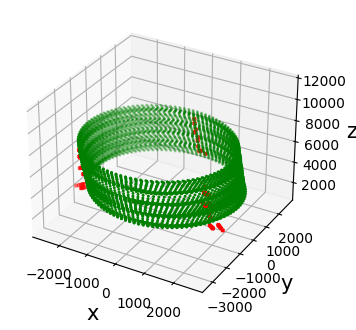

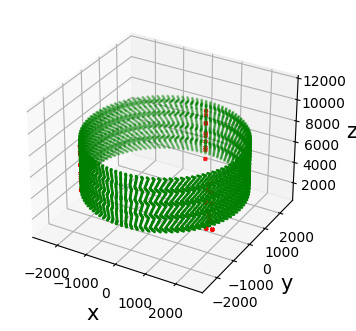

In [20]:
test_3points_rotation()

In [27]:
print(len(l.origin.T))

6


In [6]:
print(l.origin.shape == l.direction.shape)

True


In [7]:
print(np.array([[1,2,3],[1,2,3]]).shape == np.array([[1,2,3]]).shape)

False
